# Optimization of an International Portfolio

In [6]:
! pip install 'pandas_datareader>=0.10'
! pip install cvxpy 
! pip install riskfolio-lib
! pip install yfinance

ERROR: Invalid requirement: "'pandas_datareader"


In [7]:
# Import the necessary libraries 
from pandas_datareader.data import DataReader
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from typing import Dict, List
import yfinance as yf
import cvxpy as cp
import riskfolio as rp
import warnings

In [8]:
# Create the formula to get the dates of the last 5 years.
def fnct_last_five_years():
    five_years = timedelta(days=365*5, )
    now = datetime.now()
    five_years_ago = now - five_years
    return now, five_years_ago

now, five_years_ago = fnct_last_five_years()
print(now)
print(five_years_ago)

2022-10-17 10:29:48.306566
2017-10-18 10:29:48.306566


In [9]:
def fnct_get_ticker_data(ticker: str, data_source: str = "yahoo") -> pd.DataFrame:
    """Get the data in the last 5 years for the specified ticker"""
    print(f'downloading data for {ticker}')
    now, five_years_ago = fnct_last_five_years()
    ticker_df = DataReader(ticker, data_source, five_years_ago, now)
    return ticker_df


def fnct_convert_currency(ticker_adj_close:pd.Series, currency:pd.Series) -> pd.Series:
    df = pd.DataFrame({"x":ticker_adj_close, "c":currency})
    # drop rows where all columns in subset are NA
    df = df.dropna(axis=0, how='all', subset=('x', 'c'))
    # fill with the value of the previous date's values
    df = df.fillna(method='ffill')
    # in case there are empty rows at the beginning, fill with following date's values
    df = df.fillna(method='bfill')
    return df['x'] * df['c']


def fnct_get_currency(*tickers):
    """obtain the currency for each ticker"""
    currencies = dict()
    for ticker in tickers:
        t = yf.Ticker(ticker, )
        currencies[ticker] = t.info["currency"]
    return currencies

def fnct_get_currencies_data(currencies:dict):
    """Use the output of get_currency to read the data for all the currencies once"""
    currencies_data = {}
    unique_currencies = set(currencies.values())
    ticker_map = {
        "USD": "MXN=X",
        "CAD": "CADMXN=X",
        "EUR": "EURMXN=X",
    }
    for c in unique_currencies:
        if c == "MXN":
            continue
        exchange = ticker_map[c]
        currencies_data[c] = fnct_get_ticker_data(exchange)['Close'] # {"USD":pd.Series, CAD:pd.Series}
    df = pd.DataFrame(currencies_data)
    df["MXN"] = 1
    return df

def fnct_get_tickers_in_mxn(currencies:List[str]):
    c_df = fnct_get_currencies_data(currencies)
    t_data = {}
    for ticker, coin in currencies.items():
        t = fnct_get_ticker_data(ticker)['Adj Close']
        t_in_mxn = fnct_convert_currency(t, c_df[coin])
        t_data[ticker] = t_in_mxn
    return pd.DataFrame(t_data)

In [10]:
def suma(a, b):
    c = a + b
    return(c)

suma(5, 7)


12

In [11]:
#tickers = ["BIMBOA.MX", "CEMEXCPO.MX", "PE&OLES.MX", "AMXL.MX", "HERDEZ.MX",
#    "BBD-B.TO", "RY.TO", "ENB.TO", 
#    "VWAGY", "SAP", "NSRGY", "EADSY",]
assets = ['JCI', 'TGT', 'CMCSA', 'CPB', 'MO', 'APA', 
        'MMC', 'JPM', 'ZION', 'PSA', 'BAX', 'BMY', 'LUV', 
        'PCAR', 'TXT', 'TMO', 'DE', 'MSFT', 'HPQ', 'SEE', 
        'VZ', 'CNP', 'NI', 'T', 'BA']
currencies = fnct_get_currency(*assets)


In [12]:
currencies

{'JCI': 'USD',
 'TGT': 'USD',
 'CMCSA': 'USD',
 'CPB': 'USD',
 'MO': 'USD',
 'APA': 'USD',
 'MMC': 'USD',
 'JPM': 'USD',
 'ZION': 'USD',
 'PSA': 'USD',
 'BAX': 'USD',
 'BMY': 'USD',
 'LUV': 'USD',
 'PCAR': 'USD',
 'TXT': 'USD',
 'TMO': 'USD',
 'DE': 'USD',
 'MSFT': 'USD',
 'HPQ': 'USD',
 'SEE': 'USD',
 'VZ': 'USD',
 'CNP': 'USD',
 'NI': 'USD',
 'T': 'USD',
 'BA': 'USD'}

In [13]:
data = fnct_get_tickers_in_mxn(currencies)


downloading data for MXN=X
downloading data for JCI
downloading data for TGT
downloading data for CMCSA
downloading data for CPB
downloading data for MO
downloading data for APA
downloading data for MMC
downloading data for JPM
downloading data for ZION
downloading data for PSA
downloading data for BAX
downloading data for BMY
downloading data for LUV
downloading data for PCAR
downloading data for TXT
downloading data for TMO
downloading data for DE
downloading data for MSFT
downloading data for HPQ
downloading data for SEE
downloading data for VZ
downloading data for CNP
downloading data for NI
downloading data for T
downloading data for BA


In [14]:
data

,JCI,TGT,CMCSA,CPB,MO,APA,MMC,JPM,ZION,PSA,...,TMO,DE,MSFT,HPQ,SEE,VZ,CNP,NI,T,BA
Date,,,,,,,,,,,,,,,,,,,,,
2017-10-17,689.704285,1012.832809,632.993568,750.686467,918.418619,735.248286,1465.707668,1641.217756,788.528232,3495.057735,...,3534.338448,2268.733485,1391.134787,361.118089,779.244652,761.970729,477.643148,432.306007,343.762416,4654.084944
2017-10-18,686.692908,1008.410594,630.229801,747.408831,914.408633,732.038056,1459.308117,1634.051895,785.085372,3479.797667,...,3518.906872,2258.827775,1385.060836,359.541380,775.842326,758.643824,475.557670,430.418479,342.261486,4633.764348
2017-10-19,703.232802,1024.960037,648.637475,750.182071,916.995152,730.461788,1486.489311,1651.895823,790.627495,3522.333408,...,3613.444004,2277.157570,1403.879097,367.034360,784.776902,774.807100,482.922257,440.012549,345.382198,4660.642696
2017-10-20,709.712535,1047.518366,654.262377,760.102708,925.969871,724.011306,1489.134466,1675.467917,802.817498,3520.368294,...,3640.108147,2288.319763,1420.095990,368.037227,803.614404,779.845654,482.110507,438.368232,343.930483,4763.376280
2017-10-22,712.765843,1052.024973,657.077128,763.372802,929.953555,727.126129,1495.540983,1682.676072,806.271359,3535.513533,...,3655.768528,2298.164514,1426.205491,369.620587,807.071694,783.200686,484.184631,440.254169,345.410132,4783.869156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-11,1024.346791,3100.128925,575.480249,975.587476,889.907528,812.253835,3057.188640,2045.884417,986.824217,5817.206395,...,10049.032748,7290.419423,4522.977815,497.224575,906.160659,721.156177,533.743887,499.030479,297.170943,2640.025796
2022-10-12,1019.232364,3079.068561,573.031114,980.484383,893.800693,813.907894,3035.726754,2069.423248,967.501773,5730.510840,...,9999.982234,7214.519345,4508.949865,493.138315,898.394520,712.643777,510.315241,483.151715,292.207916,2604.904687
2022-10-13,1047.525700,3078.654845,603.865413,1011.169932,916.684878,836.182830,3116.009612,2184.742405,1010.171162,5777.771382,...,10198.394242,7334.478176,4679.108166,519.767733,918.482694,727.115524,520.366980,504.186673,302.032587,2644.782608


In [15]:
data.columns = assets
Y =  data[assets].pct_change().dropna()
display(Y.head())
#pct_change_df = data.pct_change()

,JCI,TGT,CMCSA,CPB,MO,APA,MMC,JPM,ZION,PSA,...,TMO,DE,MSFT,HPQ,SEE,VZ,CNP,NI,T,BA
Date,,,,,,,,,,,,,,,,,,,,,
2017-10-18,-0.004366,-0.004366,-0.004366,-0.004366,-0.004366,-0.004366,-0.004366,-0.004366,-0.004366,-0.004366,...,-0.004366,-0.004366,-0.004366,-0.004366,-0.004366,-0.004366,-0.004366,-0.004366,-0.004366,-0.004366
2017-10-19,0.024086,0.016411,0.029208,0.003710,0.002829,-0.002153,0.018626,0.010920,0.007059,0.012224,...,0.026865,0.008115,0.013587,0.020840,0.011516,0.021305,0.015486,0.022290,0.009118,0.005801
2017-10-20,0.009214,0.022009,0.008672,0.013224,0.009787,-0.008831,0.001779,0.014270,0.015418,-0.000558,...,0.007379,0.004902,0.011551,0.002732,0.024004,0.006503,-0.001681,-0.003737,-0.004203,0.022043
2017-10-22,0.004302,0.004302,0.004302,0.004302,0.004302,0.004302,0.004302,0.004302,0.004302,0.004302,...,0.004302,0.004302,0.004302,0.004302,0.004302,0.004302,0.004302,0.004302,0.004302,0.004302
2017-10-23,0.008752,0.022391,-0.009169,0.019530,0.001233,-0.020890,0.007082,0.007270,0.001010,0.007540,...,0.011648,0.012432,0.009250,0.013576,0.000961,-0.002007,0.007975,0.015050,0.000761,-0.000267


In [16]:
# Building the portfolio object
port = rp.Portfolio(returns = Y)

#Calculating optimal portfolio

#Select method and estimate input parameters
method_mu = 'hist' # method to estimate expected returns based on historical data
method_cov = 'hist' # method to estimate covariance matrix based on historical data 

port.assets_stats(method_mu = method_mu, method_cov = method_cov, d = 0.94)

#Estimate optimal portfolio
model = "Classic" # Could be Classic (historical), BL (Black Litterman), or FM (FActor Model)
rm = "MV" # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility of Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk Free Rate
l = 0 # Risk aversion factor, unly useful when objective is 'Utility'

w = port.optimization(model=model, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,JCI,TGT,CMCSA,CPB,MO,APA,MMC,JPM,ZION,PSA,...,TMO,DE,MSFT,HPQ,SEE,VZ,CNP,NI,T,BA
weights,1.788868e-08,0.198683,9.796571e-09,0.000001,1.439551e-08,0.016471,7.491569e-08,1.359059e-08,1.869758e-08,1.431077e-07,...,0.277108,0.253249,0.254488,1.304065e-08,1.714977e-08,1.421687e-08,1.396925e-08,1.723071e-08,1.090627e-08,5.637350e-09


c:\Users\L00616607\Anaconda3\envs\progfin\lib\site-packages\riskfolio\PlotFunctions.py:569: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sizes2 = sizes2.append(item)
c:\Users\L00616607\Anaconda3\envs\progfin\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
c:\Users\L00616607\Anaconda3\envs\progfin\lib\site-packages\riskfolio\RiskFunctions.py:349: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)


array([<AxesSubplot:title={'center':'Copyright (c) 2020-2022, Dany Cajas. All rights reserved.'}>,
       <AxesSubplot:title={'center':'Historical Compounded Cumulative Returns'}>,
       <AxesSubplot:title={'center':'Portfolio Composition'}>,
       <AxesSubplot:title={'center':'Risk (Standard Deviation) Contribution per Asset'}>,
       <AxesSubplot:title={'center':'Portfolio Returns Histogram'}, ylabel='Probability Density'>,
       <AxesSubplot:title={'center':'Historical Uncompounded Drawdown'}>],
      dtype=object)

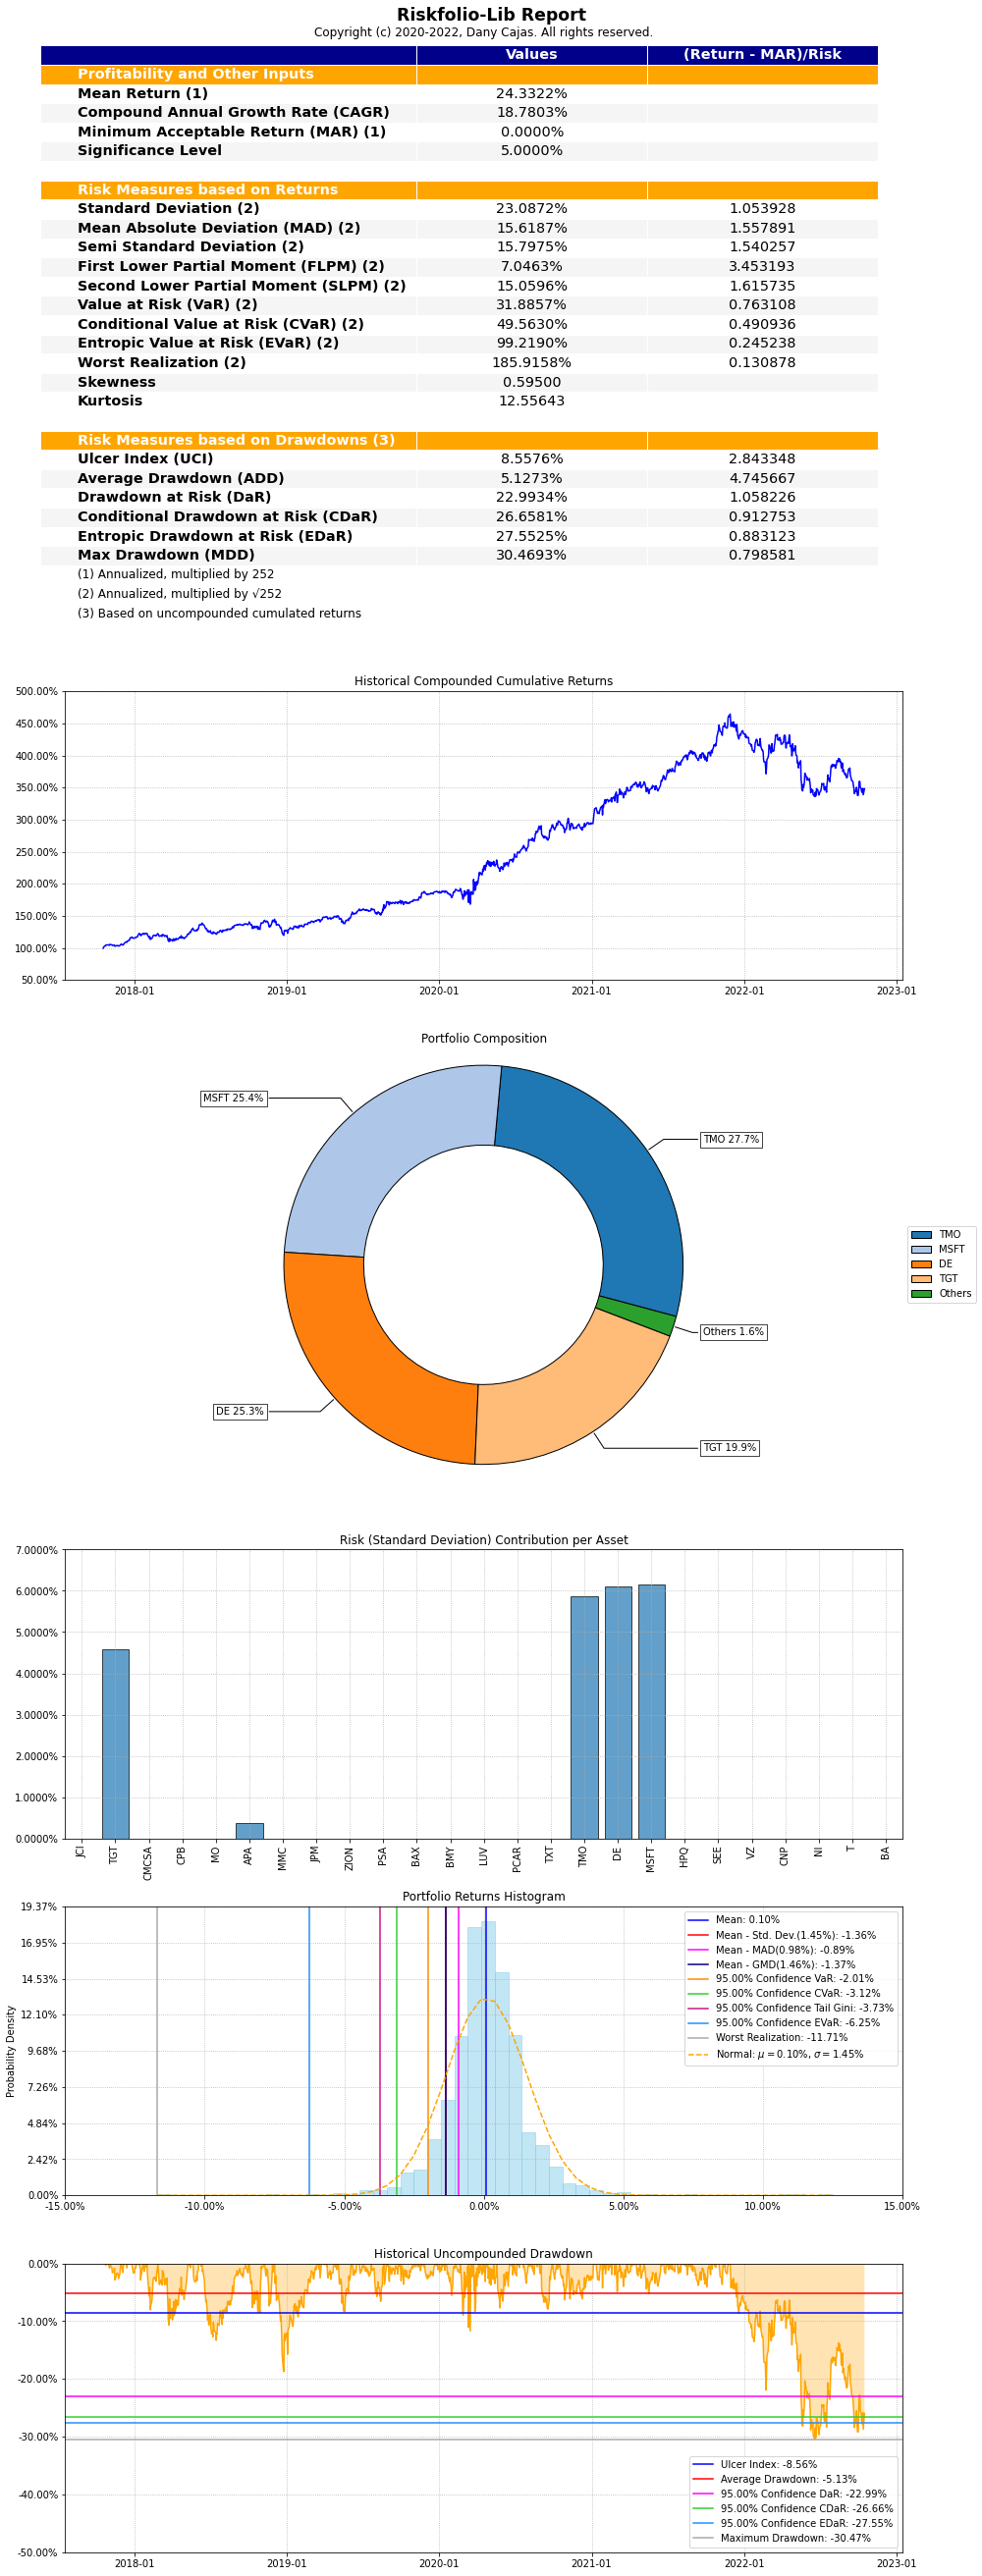

In [34]:
rp.Reports.jupyter_report(Y, w)

In [35]:
rp.Reports.excel_report(
    Y,
    w,
    rf=0,
    alpha=0.05,
    t_factor=252,
    ini_days=1,
    days_per_year=252,
    name=r"C:\Users\L00616607\Developer\ProgFin\python port1.xlsx",
)


c:\Users\L00616607\Anaconda3\envs\progfin\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
c:\Users\L00616607\Anaconda3\envs\progfin\lib\site-packages\riskfolio\RiskFunctions.py:349: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)
c:\Users\L00616607\Anaconda3\envs\progfin\lib\site-packages\xlsxwriter\workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


c:\Users\L00616607\Anaconda3\envs\progfin\lib\site-packages\riskfolio\PlotFunctions.py:569: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sizes2 = sizes2.append(item)


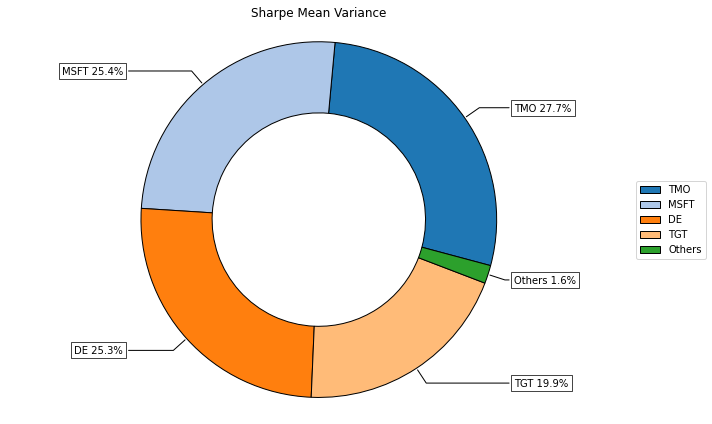

In [17]:
# Ploting the composition of the portfolio
ax = rp.plot_pie(w=w, title='Sharpe Mean Variance', others=0.05, nrow=len(data.columns), 
                cmap='tab20', height=6, width=10, ax=None)

In [19]:
ann_mean_return = ((1 + Y.mean())**252)-1
print(ann_mean_return)

JCI      0.115933
TGT      0.275732
CMCSA    0.033294
CPB      0.092021
MO       0.027632
APA      0.271488
MMC      0.170360
JPM      0.109976
ZION     0.113081
PSA      0.125148
BAX      0.027283
BMY      0.084847
LUV     -0.021063
PCAR     0.112626
TXT      0.106032
TMO      0.249513
DE       0.289205
MSFT     0.290017
HPQ      0.130075
SEE      0.089473
VZ       0.017172
CNP      0.064804
NI       0.062508
T        0.009353
BA       0.011271
dtype: float64


In [20]:
ann_stdev = Y.std() * (252**(1/2))
print(ann_stdev)

JCI      0.274580
TGT      0.331823
CMCSA    0.277959
CPB      0.276322
MO       0.255313
APA      0.652359
MMC      0.229482
JPM      0.298010
ZION     0.350642
PSA      0.240674
BAX      0.252858
BMY      0.240625
LUV      0.366004
PCAR     0.264575
TXT      0.362621
TMO      0.270296
DE       0.321626
MSFT     0.290609
HPQ      0.352056
SEE      0.322590
VZ       0.208137
CNP      0.298948
NI       0.263072
T        0.242315
BA       0.458942
dtype: float64


In [23]:
Y.cov()

,JCI,TGT,CMCSA,CPB,MO,APA,MMC,JPM,ZION,PSA,...,TMO,DE,MSFT,HPQ,SEE,VZ,CNP,NI,T,BA
JCI,0.000299,0.000142,0.000149,0.000076,0.000116,0.000237,0.000149,0.000206,0.000207,0.000108,...,0.000128,0.000200,0.000155,0.000197,0.000178,0.000090,0.000153,0.000116,0.000129,0.000244
TGT,0.000142,0.000437,0.000135,0.000107,0.000116,0.000128,0.000135,0.000145,0.000139,0.000102,...,0.000141,0.000158,0.000172,0.000167,0.000126,0.000105,0.000113,0.000113,0.000113,0.000155
CMCSA,0.000149,0.000135,0.000307,0.000080,0.000113,0.000172,0.000131,0.000185,0.000173,0.000103,...,0.000112,0.000163,0.000172,0.000170,0.000140,0.000121,0.000148,0.000136,0.000152,0.000199
CPB,0.000076,0.000107,0.000080,0.000303,0.000106,-0.000016,0.000080,0.000064,0.000040,0.000102,...,0.000080,0.000051,0.000086,0.000050,0.000068,0.000106,0.000094,0.000106,0.000095,0.000016
MO,0.000116,0.000116,0.000113,0.000106,0.000259,0.000151,0.000099,0.000136,0.000133,0.000098,...,0.000080,0.000128,0.000095,0.000114,0.000115,0.000102,0.000118,0.000115,0.000120,0.000158
APA,0.000237,0.000128,0.000172,-0.000016,0.000151,0.001689,0.000161,0.000351,0.000402,0.000040,...,0.000105,0.000319,0.000180,0.000344,0.000227,0.000050,0.000237,0.000103,0.000166,0.000526
MMC,0.000149,0.000135,0.000131,0.000080,0.000099,0.000161,0.000209,0.000165,0.000136,0.000116,...,0.000146,0.000147,0.000167,0.000150,0.000137,0.000094,0.000153,0.000124,0.000109,0.000182
JPM,0.000206,0.000145,0.000185,0.000064,0.000136,0.000351,0.000165,0.000352,0.000328,0.000098,...,0.000120,0.000234,0.000177,0.000226,0.000201,0.000111,0.000190,0.000138,0.000163,0.000325
ZION,0.000207,0.000139,0.000173,0.000040,0.000133,0.000402,0.000136,0.000328,0.000488,0.000071,...,0.000081,0.000240,0.000130,0.000231,0.000192,0.000100,0.000173,0.000124,0.000162,0.000349
PSA,0.000108,0.000102,0.000103,0.000102,0.000098,0.000040,0.000116,0.000098,0.000071,0.000230,...,0.000104,0.000104,0.000119,0.000092,0.000107,0.000095,0.000142,0.000148,0.000093,0.000121


In [31]:
w.round(4)

,weights
JCI,0.0000
TGT,0.1987
CMCSA,0.0000
CPB,0.0000
MO,0.0000
APA,0.0165
MMC,0.0000
JPM,0.0000
ZION,0.0000
PSA,0.0000


In [ ]:

#weight = np.full_like(ann_stdev,1/len(ann_stdev))
#weight

In [28]:
portaf_ann_stdev = ((w.T @ Y.cov()) @ w) ** (1/2)
portaf_ann_stdev

,weights
weights,0.014544


In [ ]:
df = pd.DataFrame({"goog":goog.Close, "cemex":cemex.Close, 'mxn':mxn['Close']})
# drop rows where all columns in subset are NA
df = df.dropna(axis=0, how='all', subset=('goog', 'cemex'))
# fill with the value of the previous date's values
df = df.fillna(method='ffill')
# in case there are empty rows at the beginning, fill with following date's values
df = df.fillna(method='bfill')

In [ ]:
#Add a column with google prices in MXN
df['goog_mxn'] = df.goog * df.mxn

In [ ]:
df.plot(y=['goog_mxn', "cemex"])

In [ ]:
df.corr()

In [ ]:
df.cov()

In [ ]:
df.std()

In [ ]:
df.std() * np.sqrt(252)

In [ ]:
df['goog_mxn_change'] = df.goog_mxn.pct_change()

In [ ]:
df.to_excel('example.xlsx')